# Práctica 5: Tech evolution. Caso POS Tagging

- Obten los embeddings de 100 palabras al azar del modelo RNN visto en clase
  - Pueden ser los embeddings estáticos o los dinámicos del modelo
- Aplica un algoritmo de clusterización a las palabras y plotearlas en 2D
  - Aplica algun color para los diferentes clusters
- Agrega al plot los embeddings de las etiquetas POS
  - Utiliza un marcador que las distinga claramente de las palabras
- Realiza una conclusión sobre los resultados observados

### Extra: 0.5pt

- Implementa una red *Long short-term memory units (LSTM)* para la tarea de etiquetado POS
- Reporta el accuracy y comparalo con los resultados de la RNN simple
- Realiza un comentario sobre como impacta la arquitectura LSTM sobre el resultado obtenido

#Funciones Creadas Durante La Clase

In [ ]:
!pip install numpy==1.26.4
!pip install -U gensim
!pip install utils
#Reiniciar entorno!

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 89.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 16.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does 

In [31]:
from rich import print as rprint
import requests
import gensim.downloader as gensim_api
from gensim.models.keyedvectors import KeyedVectors
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from torch.nn.utils.rnn import pad_sequence

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def get_raw_corpus(lang: str) -> str:
    """Obtiene el corpus crudo de Universal Dependencies

    Parameters
    ----------
    lang: str
        Idioma del corpus. Puede ser "es" o "en"

    Return
    ------
    str
        Corpus crudo en formato CoNLL
    """
    file_variants = ["train", "test", "dev"]
    result = dict.fromkeys(file_variants)
    DATASETS = {"es": ["UD_Spanish-AnCora", "es_ancora-ud"], "en": ["UD_English-GUM", "en_gum-ud"]}
    repo, file_name = DATASETS[lang]
    for variant in file_variants:
        url = f"https://raw.githubusercontent.com/UniversalDependencies/{repo}/refs/heads/master/{file_name}-{variant}.conllu"
        r = requests.get(url)
        result[variant] = r.text
    return result

In [5]:
raw_corpus = get_raw_corpus("en")
raw_spanish_corpus = get_raw_corpus("es")

In [6]:
class Token(dict):
    """Modela cada renglon de un corpus en formato CoNLL
    """
    pass

In [7]:
t = Token(
    {
        "ID": "1",
        "FORM": "Las",
        "LEMMA": "el",
        "UPOS": "DET",
        "FEATS": "Definite=Def|Gender=Fem|Number=Plur|PronType=Art",
    }
)
rprint(t)

{
    'ID': '1',
    'FORM': 'Las',
    'LEMMA': 'el',
    'UPOS': 'DET',
    'FEATS': 'Definite=Def|Gender=Fem|Number=Plur|PronType=Art'
}

In [8]:
import re

class CoNLLDictorizer:
    """Convierte un corpus en formato CoNLL a una lista de diccionarios

    Define los métodos fit, transform y fit_transform para que
    sea compatible con la api de scikit-learn.

    Parameters
    ----------
    column_names: list
        Nombre de las columnas del corpus.
        Default: ["ID", "FORM", "LEMMA", "UPOS", "XPOS", "FEATS", "HEAD", "DEPREL", "DEPS", "MISC"]
    sent_sep: str
        Separador de oraciones. Default: "\n\n"
    col_sep: str
        Separador de columnas. Default: "\t+"
    """
    DEFAULT_COLS = [
        "ID",
        "FORM",
        "LEMMA",
        "UPOS",
        "XPOS",
        "FEATS",
        "HEAD",
        "DEPREL",
        "HEAD",
        "DEPS",
        "MISC",
    ]

    def __init__(self, column_names: list=DEFAULT_COLS, sent_sep="\n\n", col_sep="\t+"):
        self.column_names = column_names
        self.sent_sep = sent_sep
        self.col_sep = col_sep

    def fit(self):
        pass

    def transform(self, corpus: str) -> list[Token]:
        """Convierte un corpus en formato CoNLL a una lista de diccionarios.

        Parameters
        ----------
        corpus: str
            Corpus en formato CoNLL

        Return
        ------
        list
            Lista de diccionarios con los tokens del corpus
        """
        corpus = corpus.strip()
        sentences = re.split(self.sent_sep, corpus)
        return list(map(self._split_in_words, sentences))

    def fit_transform(self, corpus):
        return self.transform(corpus)

    def _split_in_words(self, sentence: list[str]) -> list[Token]:
        """Preprocesa una oración en formato CoNLL

        Ignora las lineas que comienzan con "#" y separa
        cada línea en un diccionario.

        Parameters
        ----------
        sentence: str
            Oracion en formato CoNLL

        Return
        ------
        list
            Lista de diccionarios con los tokens de la oración
        """
        rows = re.split("\n", sentence)
        rows = [row for row in rows if row[0] != "#"]
        return [
            Token(dict(zip(self.column_names, re.split(self.col_sep, row))))
            for row in rows
        ]

In [9]:
conll_dict = CoNLLDictorizer()

In [10]:
corpora = {}
for variant in ["train", "test", "dev"]:
    corpora[variant] = conll_dict.transform(raw_corpus[variant])

In [11]:
spanish_corpora = {}
for variant in ["train", "test", "dev"]:
    spanish_corpora[variant] = conll_dict.transform(raw_spanish_corpus[variant])

In [12]:
def extract_pairs(sentence: list[Token], word_key="FORM", pos_key="UPOS"):
    """ Extrae las palabras y sus etiquetas POS

    Parameters
    ----------
    sentence: list[Token]
        Oracion en formato CoNLL
    word_key: str
        Nombre de la columna que contiene la palabra. Default: "FORM"
    pos_key: str
        Nombre de la columna que contiene la etiqueta POS. Default: "UPOS"

    Return
    ------
    tuple
        Tupla con las palabras y sus etiquetas POS
    """
    _input, target = [], []
    for token in sentence:
        _input += [token[word_key]]
        target += [token.get(pos_key, None)]
    return _input, target

In [13]:
train_pairs = [extract_pairs(sentence) for sentence in corpora["train"]]
val_pairs = [extract_pairs(sentence) for sentence in corpora["dev"]]
test_pairs = [extract_pairs(sentence) for sentence in corpora["test"]]

In [14]:
train_sent_words, train_sent_pos = zip(*train_pairs)
val_sent_words, val_sent_pos = zip(*val_pairs)
test_sent_words, test_sent_pos = zip(*test_pairs)

In [15]:
vectors = gensim_api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


In [16]:
def get_embeddings(model: KeyedVectors) -> dict[str, torch.FloatTensor]:
    """Obtiene los embeddings de las palabras del modelo

    Parameters
    ----------
    model: KeyedVectors
        Modelo de embeddings

    Return
    ------
    dict[str, torh.FloatTensor]
        Diccionario con las palabras como keys y los embeddings como values
    """
    embeddings = {}
    for word, idx in model.key_to_index.items():
        embeddings[word] = torch.FloatTensor(vectors[idx].copy())
    return embeddings

In [17]:
embeddings = get_embeddings(vectors)

In [18]:
# Extracting the training set
rprint(train_sent_words[0])
rprint(train_sent_pos[0])

['Aesthetic', 'Appreciation', 'and', 'Spanish', 'Art', ':']

['ADJ', 'NOUN', 'CCONJ', 'ADJ', 'NOUN', 'PUNCT']

In [19]:
# Todas las palabras a minusculas para que sea compatible con GLoVe
train_sent_words_rnn = [list(map(str.lower, sentence)) for sentence in train_sent_words]
val_sent_words_rnn = [list(map(str.lower, sentence)) for sentence in val_sent_words]
test_sent_words_rnn = [list(map(str.lower, sentence)) for sentence in test_sent_words]

##Indices

In [20]:
corpus_words_rnn = sorted(set([word for sentence in train_sent_words_rnn for word in sentence]))
pos_list_rnn = sorted(set([pos for sentence in train_sent_pos for pos in sentence]))

In [21]:
embeddings_words_rnn = embeddings.keys()
vocabulary = set(corpus_words_rnn + list(embeddings_words_rnn))

In [22]:
# Start on 2 because id 0 will be pad simbol and 1 will be UNK
idx2word = dict(enumerate(vocabulary), start=2)
idx2pos = dict(enumerate(pos_list_rnn), start=1)

word2idx = {v: k for k, v in idx2word.items()}
pos2idx = {v: k for k, v in idx2pos.items()}

In [23]:
def to_index(corpus: list[list[str]], word2idx: dict[str, int], unk_id: int = 1) -> torch.LongTensor:
    indexes = []
    for sent in corpus:
        sent_indexes = torch.LongTensor(
            list(map(lambda word: word2idx.get(word, unk_id), sent))
        )
        indexes += [sent_indexes]
    return indexes

In [24]:
t = to_index(train_sent_words_rnn[:2], word2idx)

In [25]:
for sent in t:
    for word in sent:
        print(idx2word[int(word)])

aesthetic
appreciation
and
spanish
art
:
insights
from
eye
-
tracking


In [26]:
X_train_idx_rnn = to_index(train_sent_words_rnn, word2idx)
Y_train_idx_rnn = to_index(train_sent_pos, pos2idx)

In [27]:
X_val_idx_rnn = to_index(val_sent_words_rnn, word2idx)
Y_val_idx_rnn = to_index(val_sent_pos, pos2idx)

In [28]:
X_test_idx_rnn = to_index(test_sent_words_rnn, word2idx)
Y_test_idx_rnn = to_index(test_sent_pos, pos2idx)

##Padding

In [32]:
pad_sequence(X_train_idx_rnn[41:43], batch_first=True, padding_value=0)

tensor([[390746, 193491, 205260, 370427, 155267,  32373,  16878, 338846, 214997,
          99673, 399986,   7421,  21748, 229740, 219225, 228296, 177220, 303973,
         102028, 381094, 269402,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0],
        [345818, 214997,  99673,  94760, 273377,  42950,  91467, 328497,   9656,
         205260, 265235,  48255, 205260, 229740, 326649, 190559, 399059, 214997,
         136099, 208112, 238277, 141154, 220094, 327294, 205260, 130137, 205260,
         228296, 367000, 186458, 280428,  10217, 269402]])

In [33]:
X_train_rnn = pad_sequence(X_train_idx_rnn, batch_first=True, padding_value=0)
Y_train_rnn = pad_sequence(Y_train_idx_rnn, batch_first=True, padding_value=0)

In [34]:
X_val_rnn = pad_sequence(X_val_idx_rnn, batch_first=True, padding_value=0)
Y_val_rnn = pad_sequence(Y_val_idx_rnn, batch_first=True, padding_value=0)

In [35]:
X_test_rnn = pad_sequence(X_test_idx_rnn, batch_first=True, padding_value=0)
Y_test_rnn = pad_sequence(Y_test_idx_rnn, batch_first=True, padding_value=0)

##Embeddings para RNN

In [36]:
EMBEDDING_DIM = 100

In [37]:
embedding_table = torch.randn((len(vocabulary) + 2, EMBEDDING_DIM)) / 10

In [38]:
for word in vocabulary:
    if word in embeddings:
        embedding_table[word2idx[word]] = embeddings[word]

#La RNN con pytorch

In [39]:
class RnnModel(nn.Module):
    def __init__(self,
                 embedding_table,
                 hidden_size,
                 num_classes: int,
                 freeze_embeddings: bool = False,
                 num_layers: int=1,
                 bidirectional=False):
        super().__init__()
        embedding_dim = embedding_table.size(dim=-1)
        self.embedding = nn.Embedding.from_pretrained(
            embedding_table,
            freeze=freeze_embeddings,
            padding_idx=0
            )
        self.recurrent = nn.RNN(
            embedding_dim,
            hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True
        )
        if bidirectional:
            # Dos veces las unidades si es bidireccional
            self.linear = nn.Linear(hidden_size * 2, num_classes)
        else:
            self.linear = nn.Linear(hidden_size, num_classes)

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        rec_out, _ = self.recurrent(embeds)
        logist = self.linear(rec_out)
        return logist

In [40]:
rnn_model = RnnModel(
    embedding_table,
    hidden_size=128,
    num_classes=len(pos2idx) + 1,
    freeze_embeddings=False,
    num_layers=2,
    bidirectional=True
).to(device)

In [41]:
loss_fn = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.NAdam(rnn_model.parameters(), lr=0.005)

###Trainingloop

In [42]:
EPOCHS = 10

In [43]:
train_dataset_rnn = TensorDataset(X_train_rnn, Y_train_rnn)
train_dataloader_rnn = DataLoader(train_dataset_rnn, batch_size=512, shuffle=True)

In [44]:
val_dataset_rnn = TensorDataset(X_val_rnn, Y_val_rnn)
val_dataloader_rnn = DataLoader(val_dataset_rnn, batch_size=2048, shuffle=False)

In [45]:
test_dataset_rnn = TensorDataset(X_test_rnn, Y_test_rnn)
test_dataloader_rnn = DataLoader(test_dataset_rnn, batch_size=2048, shuffle=False)

In [46]:
def evaluate_rnn(model: nn.Module, loss_fn: nn.Module, dataloader: DataLoader):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        accuracy = 0
        t_words = 0
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch_pred = model(X_batch)
            current_loss = loss_fn(
                y_batch_pred.reshape(-1, y_batch_pred.size(dim=-1)),
                y_batch.reshape(-1)
            )
            n_words = torch.sum(y_batch > 0).item()
            t_words += n_words
            total_loss += n_words + current_loss.item()
            accuracy += torch.mul(
                torch.argmax(y_batch_pred, dim=-1) == y_batch,
                y_batch > 0).sum().item()
        return total_loss / t_words, accuracy / t_words

In [50]:
import os

# Crear el directorio si no existe
MODELS_PATH = "./models"
os.makedirs(MODELS_PATH, exist_ok=True)


In [51]:
rnn_history = {"accuracy": [], "loss": [], "val_loss": [], "val_accuracy": []}
for epoch in trange(EPOCHS):
    train_loss, train_acc, t_words = 0, 0, 0
    rnn_model.train()
    for X_batch, y_batch in tqdm(train_dataloader_rnn):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch_pred = rnn_model(X_batch)
        loss = loss_fn(
            y_batch_pred.reshape(-1, y_batch_pred.size(dim=-1)),
            y_batch.reshape(-1)
            )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            n_words = torch.sum(y_batch > 0).item()
            t_words += n_words
            train_loss += n_words * loss.item()
            train_acc += torch.mul(
                torch.argmax(y_batch_pred, dim=-1) == y_batch,
                y_batch > 0).sum().item()

    rnn_model.eval()
    with torch.no_grad():
        rnn_history["accuracy"].append(train_acc / t_words)
        rnn_history["loss"].append(train_loss / t_words)
        val_loss, val_acc = evaluate_rnn(rnn_model, loss_fn, val_dataloader_rnn)
        rnn_history["val_loss"].append(val_loss)
        rnn_history["val_accuracy"].append(val_acc)
    torch.save(rnn_model.state_dict(), f"{MODELS_PATH}/pos_tagger_rnn_{device}_{epoch}.pth")
torch.save(rnn_history, f"{MODELS_PATH}/pos_tagger_rnn.history")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [52]:
def plot_history(history: dict) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(history["accuracy"], label="Accuracy")
    axes[0].plot(history["val_accuracy"], label="Validation accuracy")
    axes[0].set_title("Accuracy")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()

    axes[1].plot(history["loss"], label="Loss")
    axes[1].plot(history["val_loss"], label="Validation loss")
    axes[1].set_title("Loss")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].legend()

    plt.show()

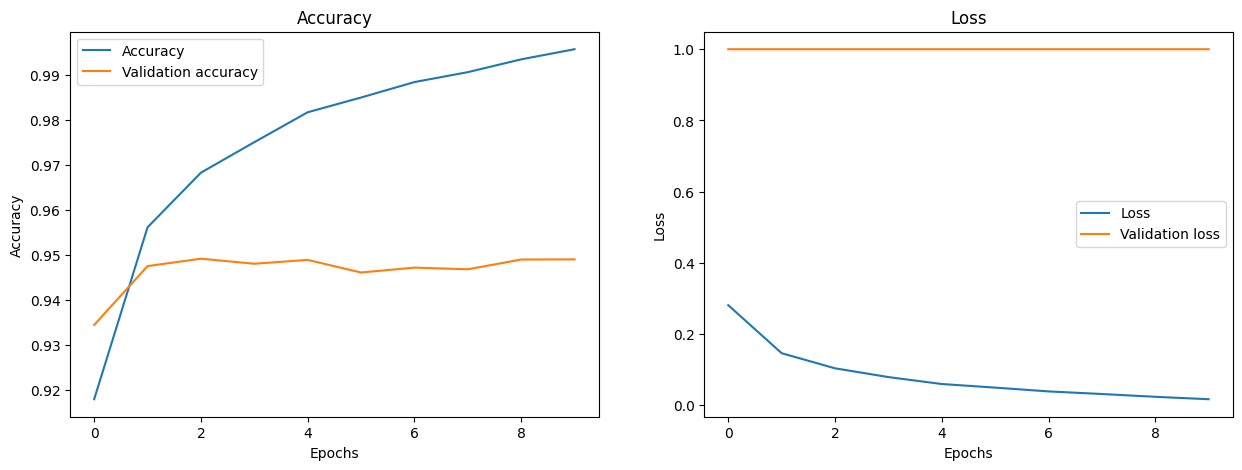

In [53]:
plot_history(rnn_history)

In [54]:
_, accuracy_rnn = evaluate_rnn(rnn_model, loss_fn, test_dataloader_rnn)
rprint(f"Accuracy (RNN): {accuracy_rnn * 100:.2f}%")

Accuracy (RNN): 94.23%

#Primer ejercicio

- Obten los embeddings de 100 palabras al azar del modelo RNN visto en clase
  - Pueden ser los embeddings estáticos o los dinámicos del modelo

##Embeddings estáticos

In [95]:
import random

# Seleccionar 100 palabras aleatorias del vocabulario
random_words = random.sample(list(word2idx.keys()), 100)

# Obtener los índices de estas palabras
word_indices = torch.tensor([word2idx[word] for word in random_words]).to(device)

# Obtener los embeddings estáticos
with torch.no_grad():
    static_embeddings = rnn_model.embedding(word_indices).cpu().numpy()

# Mostrar algunas palabras y la forma de los embeddings
print(f"Embeddings estáticos para {len(random_words)} palabras")
print(f"Forma de los embeddings: {static_embeddings.shape}")
print("\nEjemplos:")
for i in range(99):
    print(f"Palabra: {random_words[i]}")
    print(f"Embedding (primeros 5 valores): {static_embeddings[i][:5]}")

Embeddings estáticos para 100 palabras
Forma de los embeddings: (100, 100)

Ejemplos:
Palabra: leia
Embedding (primeros 5 valores): [ 0.16739  -0.17466  -0.14196   0.030429  0.41072 ]
Palabra: filipinos
Embedding (primeros 5 valores): [ 0.36199   0.88105  -0.496    -0.3913   -0.071198]
Palabra: 7.85
Embedding (primeros 5 valores): [ 0.55331  0.41292  0.23334  0.13985 -0.11996]
Palabra: levier
Embedding (primeros 5 valores): [-0.057408  -0.20377   -0.0031278  0.29105   -0.35732  ]
Palabra: dullest
Embedding (primeros 5 valores): [-0.14081  0.21055  0.34692  0.21454 -0.13023]
Palabra: 8:38
Embedding (primeros 5 valores): [-0.43567  -0.18503  -0.037366  0.55285  -0.44005 ]
Palabra: healthyeating
Embedding (primeros 5 valores): [-0.17988   0.46029   0.20182   0.37777  -0.079765]
Palabra: lasius
Embedding (primeros 5 valores): [-0.1275   -0.37134  -0.059139 -0.14335  -0.25432 ]
Palabra: ashan
Embedding (primeros 5 valores): [-0.066507 -0.014649 -0.37036   0.42861  -0.22307 ]
Palabra: viejo


#Segundo Ejercicio

- Aplica un algoritmo de clusterización a las palabras y plotearlas en 2D
  - Aplica algun color para los diferentes clusters

<ipython-input-96-368956f49728>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_clusters)  # Paleta de colores


<Figure size 1200x800 with 0 Axes>

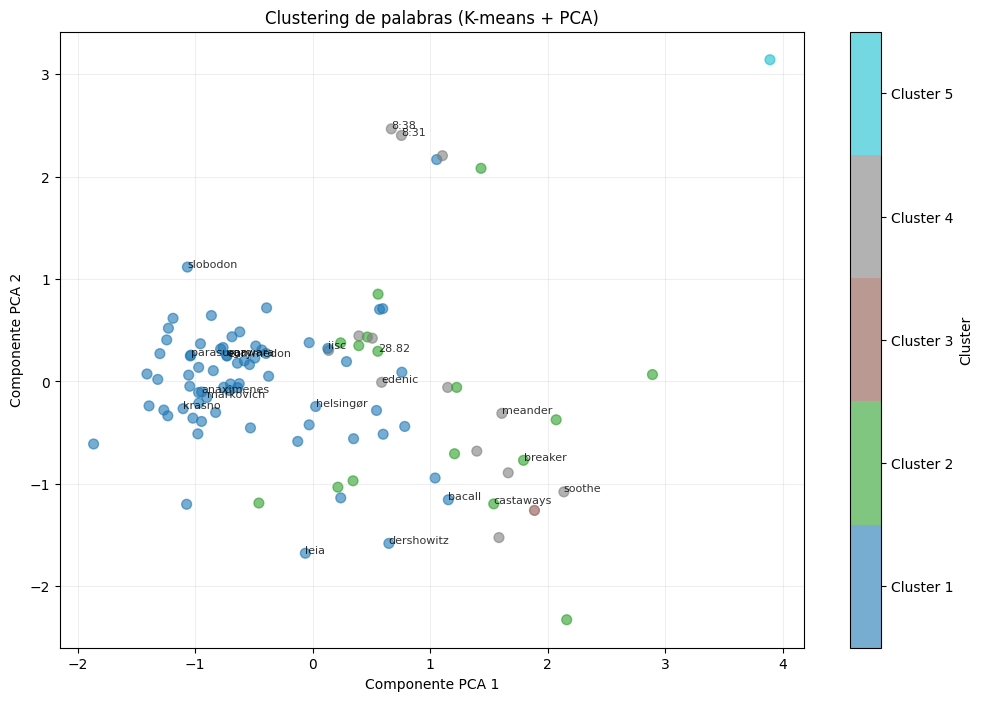

In [96]:

# 3. Reducir dimensionalidad a 2D con PCA (para visualización)
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(static_embeddings)

# 4. Aplicar K-means para clusterizar las palabras en 5 grupos
n_clusters = 5  # Puedes ajustar este valor
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(static_embeddings)

# 5. Graficar con colores por cluster
plt.figure(figsize=(12, 8))
colors = plt.cm.get_cmap('tab10', n_clusters)  # Paleta de colores

# Scatter plot con colores según el cluster
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=clusters, cmap='tab10', alpha=0.6, s=50
)

# Etiquetar palabras (opcional)
for i, word in enumerate(random_words):
    if i % 5 == 0:
        plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                    fontsize=8, alpha=0.8)

# Colorbar con clusters enteros
cbar = plt.colorbar(scatter, label='Cluster',
                    ticks=np.arange(n_clusters),
                    boundaries=np.arange(n_clusters+1)-0.5)
cbar.set_ticklabels([f'Cluster {i+1}' for i in range(n_clusters)])

plt.title("Clustering de palabras (K-means + PCA)")
plt.xlabel("Componente PCA 1")
plt.ylabel("Componente PCA 2")
plt.grid(alpha=0.2)
plt.show()

#Tercer Ejercicio

- Agrega al plot los embeddings de las etiquetas POS
  - Utiliza un marcador que las distinga claramente de las palabras

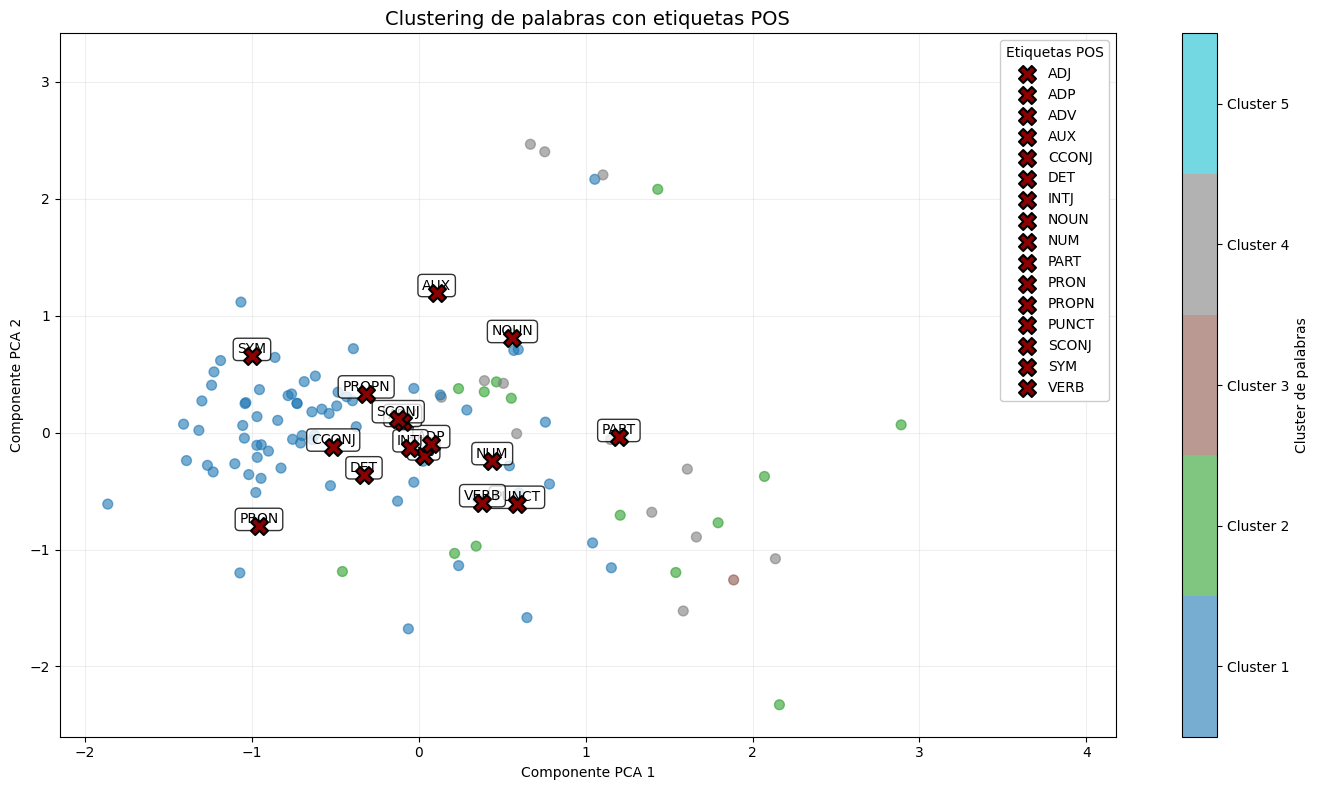

In [105]:
# Obtener embeddings POS desde la capa lineal del modelo
pos_embeddings_dynamic = {
    pos: rnn_model.linear.weight.data.cpu().numpy()[int(pos_id)-1]  # -1 porque el padding es 0
    for pos, pos_id in pos2idx.items()
    if pos not in ['_', 'X', '<pad>'] and str(pos_id).isdigit()  # Filtramos tags especiales
}


# Reducción de dimensionalidad para POS
pca_pos = PCA(n_components=2)
pos_embs = np.array(list(pos_embeddings_dynamic.values()))
pos_2d = pca_pos.fit_transform(pos_embs)
pos_tags = list(pos_embeddings_dynamic.keys())

# Configuración del gráfico
plt.figure(figsize=(14, 8))

# 1. Graficar palabras (clusters)
scatter_words = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=clusters, cmap='tab10', alpha=0.6, s=50
)

# 2. Graficar POS con etiquetas individuales en la leyenda
pos_markers = []
for i, pos in enumerate(pos_tags):
    # Graficar cada POS
    marker = plt.scatter(
        pos_2d[i, 0], pos_2d[i, 1],
        marker='X', s=150, edgecolor='black', linewidth=1.5,
        color='darkred', zorder=4,
        label=pos  # Etiqueta individual para la leyenda
    )
    plt.annotate(pos, (pos_2d[i, 0], pos_2d[i, 1]),
                fontsize=10, ha='center', va='bottom',
                bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8))
    pos_markers.append(marker)

# 3. Colorbar con valores enteros
cbar = plt.colorbar(
    scatter_words,
    label='Cluster de palabras',
    ticks=np.arange(n_clusters),
    boundaries=np.arange(n_clusters+1)-0.5
)
cbar.set_ticklabels([f'Cluster {i+1}' for i in range(n_clusters)])

# 4. Leyenda para POS (todas las etiquetas)
plt.legend(
    handles=pos_markers,
    labels=pos_tags,
    title="Etiquetas POS",
    loc='upper right',
    framealpha=1,
    handletextpad=0.5
)

# Ajustes finales
plt.title("Clustering de palabras con etiquetas POS", fontsize=14)
plt.xlabel("Componente PCA 1")
plt.ylabel("Componente PCA 2")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

En base a lo observado podemos decir que el modelo RNN logra agrupar palabras que tienen cierta relación entre sí, ya sea por su significado o por cómo se usan en el lenguaje. Al aplicar clustering y reducir la dimensión con PCA, se forman grupos bastante coherentes, aunque no siempre corresponden a una sola categoría gramatical. Al agregar las etiquetas POS, se nota que están distribuidas en distintas zonas del espacio, lo que indica que el modelo también está captando diferencias en la función de las palabras. Algunos puntos quedan más aislados, probablemente porque son palabras menos comunes o con un uso más específico. En general, los resultados son buenos considerando que se usaron embeddings estáticos, aunque usar embeddings dinámicos podría ayudar a reflejar mejor el contexto en el que se usan las palabras.
